# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.218115,True,5.192952
1,-2.214109,False,-5.511422
2,-1.604225,False,-2.343443
3,-1.730743,False,-2.996998
4,-2.448299,False,-4.277865
...,...,...,...
995,-2.522898,False,-5.839558
996,0.204025,False,-0.192892
997,-1.183591,False,-3.312228
998,-3.190273,False,-6.103659


<Axes: xlabel='v0'>

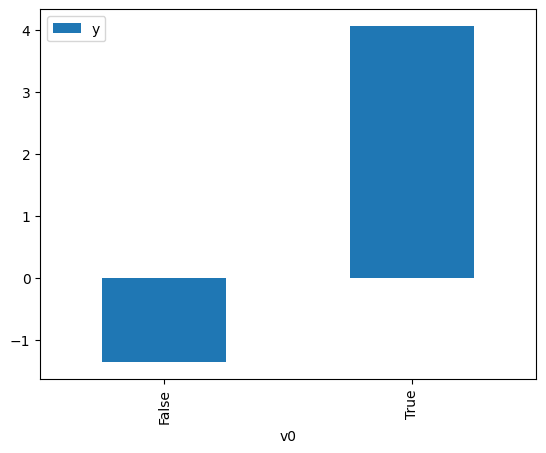

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

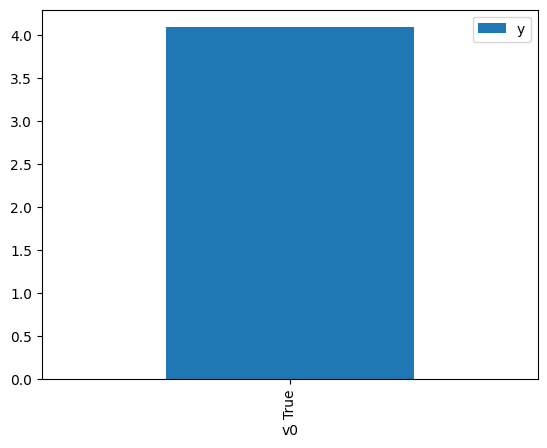

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.155910,False,-3.533915,0.976749,1.023804
1,-0.441365,False,-1.525737,0.704672,1.419100
2,-0.067522,False,-1.295933,0.560761,1.783292
3,-1.382885,False,-2.705320,0.920173,1.086752
4,-0.901488,False,-1.921900,0.837450,1.194100
...,...,...,...,...,...
995,-1.336045,False,-3.185294,0.914225,1.093823
996,-2.543715,False,-4.624259,0.987710,1.012443
997,-2.254571,False,-3.938416,0.980217,1.020183
998,-1.977254,False,-3.226152,0.968902,1.032096


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.372984,True,1.117957,0.081052,12.337750
1,0.617011,True,4.452866,0.711133,1.406206
2,0.493633,True,6.485472,0.666967,1.499325
3,-1.276278,True,0.402929,0.093948,10.644226
4,0.166752,True,3.515391,0.536849,1.862721
...,...,...,...,...,...
995,-1.599239,True,1.807711,0.056967,17.554155
996,-1.276278,True,0.402929,0.093948,10.644226
997,-1.276278,True,0.402929,0.093948,10.644226
998,-0.225997,True,5.033551,0.375343,2.664227


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              6698.
Date:                Tue, 30 Jan 2024   Prob (F-statistic):                        0.00
Time:                        17:49:22   Log-Likelihood:                         -1385.5
No. Observations:                1000   AIC:                                      2775.
Df Residuals:                     998   BIC:                                      2785.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7779      0.024     75.608      0.000       1.732       1.824
x2             5.0044      0.059     85.216      0.000       4.889       5.120
==============================================================================
Omnibus:                        4.605   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                5.538
Skew:                           0.021   Prob(JB):                       0.0627
Kurtosis:                       3.362   Cond. No.                         2.50
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""